In [1]:
import numpy as np  # To load numpy
import pandas as pd # To load pandas
import math # To calcuate mathematical problems
import time #To calculate the time that take implement the algorithm
from sklearn.model_selection import train_test_split  # for split arrays or matrices into random train and test subsets   
from sklearn import metrics   # importing metrics from sklearn to findout the performance measures.
from sklearn.svm import SVC# here we are importing svm from sklearn
from sklearn import svm # here we are importing svm from sklearn
import matplotlib.pyplot as plt  #To plot the graphs 

In [2]:
#Load USPS Dataset from HDF5 file
import h5py
usps="usps.h5"
with h5py.File(usps, 'r') as hf: #the dataset fetch in reading format
        train = hf.get('train')
        x_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        x_test = test.get('data')[:]
        y_test = test.get('target')[:]

In [3]:
x_train#Display the elements of x_train set

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.1645, 0.086 , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float32)

In [4]:
y_train#Display the elements of y_train set

array([6, 5, 4, ..., 3, 0, 1])

In [5]:
x_test #Display the elements of x_test set

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
y_test #Display the elements of y_test set

array([9, 6, 3, ..., 4, 0, 1])

In [7]:
#Splitting the dataset into training set, test set and calibration set
x_train_proper, x_cal, y_train_proper, y_cal = train_test_split(x_train, y_train, random_state=0)

print('X_train_proper: ' + str(x_train_proper.shape))#size of training set, test set and calibration set
print('Y_train_proper: ' + str(y_train_proper.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))
print('X_cal:  '  + str(x_cal.shape))
print('Y_cal:  '  + str(y_cal.shape))
print("Training Proper Size:", len(x_train))
print("Calibration Set Size:",len(x_cal))
print("Test Set Size:",len(x_test))

X_train_proper: (5468, 256)
Y_train_proper: (5468,)
X_test:  (2007, 256)
Y_test:  (2007,)
X_cal:  (1823, 256)
Y_cal:  (1823,)
Training Proper Size: 7291
Calibration Set Size: 1823
Test Set Size: 2007


#### SVM Inductive when kernel = "linear"

In [8]:
#Implement SVM when kernel = linear
from sklearn import metrics
start_time = time.time() # Calculate the total run time 
print("Total run time is: %s seconds " % (time.time() - start_time))
svc = svm.SVC(kernel='linear')
svc.fit(x_train_proper, y_train_proper)
y_pred = svc.predict(x_test)
print("Accuracy of SVM :",metrics.accuracy_score(y_test,y_pred))#Accuracy

Total run time is: 0.0 seconds 
Accuracy of SVM : 0.9207772795216741


In [9]:
def set_variables(y_train_proper,x_test):
    #Initialize variables for storage
    total_p_values=0 #Initialize the variable for total sum of p-values
    p_values=np.zeros((len(x_test),len(set(y_train_proper))))#Initialize the variable for p-values
    prediction=np.zeros(len(x_test))#Initialize the variable for prediction
    confidence=np.zeros(len(x_test))#Initialize the variable for Confidence
    credibility=np.zeros(len(x_test))#Initialize the variable for credibility
    false_p_value=np.zeros(len(x_test)) #Initialize the variable for false_p_value
    return total_p_values, p_values,prediction, confidence, credibility, false_p_value #return the values

Implementing Inductive conformal prediction algorithm in SVM with kernel =linear and regular p-value

In [10]:
#Implementing Inductive conformal prediction algorithm when kernel =linear with regular p-value
def svm_icp_linear(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test):#A defining a function svm_icp_linear and with arguments
    #calling the function set_variables
    total_p_values, p_values, prediction, confidence, credibility, false_p_value = \
    set_variables(y_train_proper,x_test) 
    cal_fun=svc.decision_function(x_cal)#Calculate non-conformity scores for the calibration set
    row=np.arange(0,len(cal_fun))
    ncs_cal=-1*cal_fun[row,y_cal]
    test_fun=svc.decision_function(x_test)#Calculate non-conformity scores for the test set
    #Loop through test samples
    for i in range(len(x_test)):
        for j in set(y_train_proper): #Test all possible labels
            ncs_test=np.append(ncs_cal,(-1*test_fun[i][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(ncs_test>=ncs_test[-1])
         #Use p-values of test sample to calculate various measures   
        prediction[i]=int(np.argmax(p_values[i]))#Measure prediction
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]#Measure Confidence
        credibility[i]=np.max(p_values[i])#Measure credibility
        total_p_values = total_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]#Measure total sum of p-values
    false_p_value=total_p_values/(2*len(x_test))#Measure false_p_value
    return prediction, confidence, credibility, p_values, false_p_value


SVM Point Prediction algorithm with kernel='linear' and smooth = False

In [11]:
start_time = time.time() # Calculate the total run time 
icp=svm_icp_linear(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test) # Calling the function icp where kernel =linear and smooth =false
print("Total run time is: %s seconds " % (time.time() - start_time))#Result of the total run time
print(" Accuracy of icp with linear kernel and regular p-value: ", np.mean(icp[0]==y_test))#Result of the Accuracy
print("Average False p-value: ", icp[4])#Result the Average False p-value
print("Average Credibility: ",np.mean(icp[2]))#Result of the Average Credibility
print("Average Confidence: ",np.mean(icp[1]))#Result of the Average Confidence


Total run time is: 2.7336933612823486 seconds 
 Accuracy of icp with linear kernel and regular p-value:  0.9217737917289487
Average False p-value:  0.03784301545468041
Average Credibility:  0.5221499969405328
Average Confidence:  0.9693733664629935


#Plotting the validity curve with different significance level were kernel='linear' and smooth = False

Text(0.5, 1.0, 'Inductive SVM Validity Curve with smoothed p-value=false and kernel=linear')

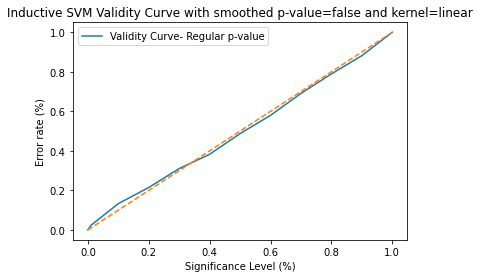

In [12]:
error_rate_smooth_linear=[]#Initialize errorrate
significance_level=[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]#assign  different significance level
for point in significance_level : #Loop with different significance level
    prediction_set=[0] * len(x_test)#Initialize the variables
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(icp[3][i]>(point))[0]) 
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth_linear=np.append(error_rate_smooth_linear,error/len(x_test))#calculate error rate
plt.plot(significance_level,error_rate_smooth_linear)#plot te graph with error rate and significance level
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.plot([0,1],[0,1],"--")
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)",)
plt.title("Inductive SVM Validity Curve with smoothed p-value=false and kernel=linear")

Implementing Inductive conformal prediction algorithm in SVM with kernel =linear and smoothed p-value

In [13]:
#Implementing Inductive conformal prediction algorithm when kernel =linear with smoothed p-value
def svm_icp_linear_smooth(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test):#A defining a function svm_icp_linear_smooth
    #calling the function set_variables
    total_p_values, p_values, prediction, confidence, credibility, false_p_value = \
    set_variables(y_train_proper,x_test) 
    cal_fun=svc.decision_function(x_cal)#Calculate non-conformity scores for the calibration set
    row=np.arange(0,len(cal_fun))
    ncs_cal=-1*cal_fun[row,y_cal]
    test_fun=svc.decision_function(x_test)#Calculate non-conformity scores for the test set
    #Loop through test samples
    for i in range(len(x_test)):
        for j in set(y_train_proper): #Test all possible labels
            ncs_test=np.append(ncs_cal,(-1*test_fun[i][j]))
            #Calculate p-values of test sample
           #smooth == True:
            tau=np.random.uniform()
            p_values[i][j]=(np.sum(ncs_test>ncs_test[-1])+(tau*(np.sum(ncs_test==ncs_test[-1]))))/len(ncs_test)
         #Use p-values of test sample to calculate various measures   
        prediction[i]=int(np.argmax(p_values[i]))#Measure prediction
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]#Measure Confidence
        credibility[i]=np.max(p_values[i])#Measure credibility
        total_p_values = total_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]#Measure total sum of p-values
    false_p_value=total_p_values/(2*len(x_test))#Measure false_p_value
    return prediction, confidence, credibility, p_values, false_p_value


In [14]:
start_time = time.time() # Calculate the total run time 
icp=svm_icp_linear_smooth(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test) # Calling the function svm_icp_linear_smooth where kernel =linearand smooth =True
print("Total run time is: %s seconds " % (time.time() - start_time))#Result of the total run time
print(" Accuracy of icp with linear kernel and regular p-value: ", np.mean(icp[0]==y_test))#Result of the Accuracy
print("Average False p-value: ", icp[4])#Result the Average False p-value
print("Average Credibility: ",np.mean(icp[2]))#Result of the Average Credibility
print("Average Confidence: ",np.mean(icp[1]))#Result of the Average Confidence


Total run time is: 3.092069387435913 seconds 
 Accuracy of icp with linear kernel and regular p-value:  0.9217737917289487
Average False p-value:  0.03660745857351655
Average Credibility:  0.5218759888596938
Average Confidence:  0.9696489162848626


Validity curve with  kernel='linear' and smooth = True

Text(0.5, 1.0, 'Inductive SVM Validity Curve with smoothed p-value=True and kernel=linear')

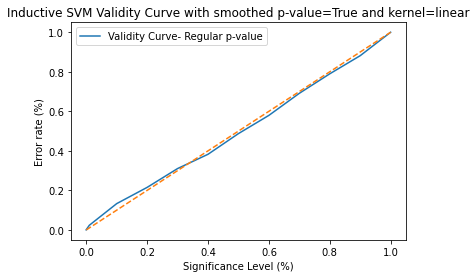

In [15]:
error_rate_smooth_linear=[]#Initialize errorrate
significance_level=[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]#assign  different significance level
for point in significance_level : #Loop with different significance level
    prediction_set=[0] * len(x_test)#Initialize the variables
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(icp[3][i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth_linear=np.append(error_rate_smooth_linear,error/len(x_test))#calculate error rate
plt.plot(significance_level,error_rate_smooth_linear)#plot te graph with error rate and significance level
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.plot([0,1],[0,1],"--")
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)",)
plt.title("Inductive SVM Validity Curve with smoothed p-value=True and kernel=linear")

#### Implement SVM when kernel = "rbf"

In [16]:
#Implement SVM when kernel = rbf
from sklearn import metrics
start_time = time.time() # Calculate the total run time 
print("Total run time is: %s seconds " % (time.time() - start_time))
svc_rbf = svm.SVC(kernel='rbf')
svc_rbf.fit(x_train_proper, y_train_proper)
y_pred = svc_rbf.predict(x_test)
print("Accuracy of SVM :",metrics.accuracy_score(y_test,y_pred))#Accuracy

Total run time is: 0.0 seconds 
Accuracy of SVM : 0.9451918285999004


Implementing Inductive conformal prediction algorithm in SVM with kernel =rbf and regular p-value

In [17]:
#Implementing Inductive conformal prediction algorithm when kernel =rbf with regular p-value
def svm_icp_rbf(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test):#A defining a function svm_icp_rbf and with arguments
    #calling the function set_variables
    total_p_values, p_values, prediction, confidence, credibility, false_p_value = \
    set_variables(y_train_proper,x_test) 
    cal_fun=svc_rbf.decision_function(x_cal)#Calculate non-conformity scores for the calibration set
    row=np.arange(0,len(cal_fun))
    ncs_cal=-1*cal_fun[row,y_cal]
    test_fun=svc_rbf.decision_function(x_test)#Calculate non-conformity scores for the test set
    #Loop through test samples
    for i in range(len(x_test)):
        for j in set(y_train_proper): #Test all possible labels
            ncs_test=np.append(ncs_cal,(-1*test_fun[i][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(ncs_test>=ncs_test[-1])
         #Use p-values of test sample to calculate various measures   
        prediction[i]=int(np.argmax(p_values[i]))#Measure prediction
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]#Measure Confidence
        credibility[i]=np.max(p_values[i])#Measure credibility
        total_p_values = total_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]#Measure total sum of p-values
    false_p_value=total_p_values/(2*len(x_test))#Measure false_p_value
    return prediction, confidence, credibility, p_values, false_p_value

In [18]:
start_time = time.time() # Calculate the total run time 
icp_rbf=svm_icp_rbf(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test) # Calling the function svm_icp_rbf where kernel =rbf and smooth =false
print("Total run time is: %s seconds " % (time.time() - start_time))#Result of the total run time
print(" Accuracy of icp with rbf kernel and regular p-value: ", np.mean(icp_rbf[0]==y_test))#Result of the Accuracy
print("Average False p-value: ", icp_rbf[4])#Result the Average False p-value
print("Average Credibility: ",np.mean(icp_rbf[2]))#Result of the Average Credibility
print("Average Confidence: ",np.mean(icp_rbf[1]))#Result of the Average Confidence

Total run time is: 3.5918662548065186 seconds 
 Accuracy of icp with rbf kernel and regular p-value:  0.9456900847035377
Average False p-value:  0.019194059825697826
Average Credibility:  0.47426933364802143
Average Confidence:  0.9840219320098952


Validity curve with kernel='rbf' and smooth = False

Text(0.5, 1.0, 'Inductive SVM Validity Curve with smoothed p-value=false and kernel=rbf')

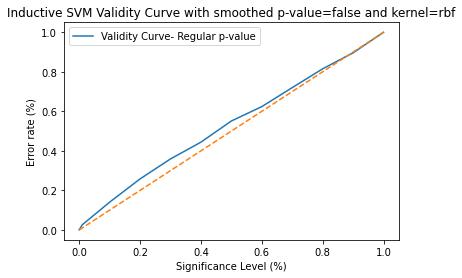

In [19]:
error_rate_smooth_rbf=[]#Initialize errorrate
significance_level=[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]#assign  different significance level
for point in significance_level : #Loop with different significance level
    prediction_set=[0] * len(x_test)#Initialize the variables
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(icp_rbf[3][i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth_rbf=np.append(error_rate_smooth_rbf,error/len(x_test))#calculate error rate
plt.plot(significance_level,error_rate_smooth_rbf)#plot te graph with error rate and significance level
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.plot([0,1],[0,1],"--")
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)",)
plt.title("Inductive SVM Validity Curve with smoothed p-value=false and kernel=rbf")

Implementing Inductive conformal prediction algorithm in SVM with kernel =rbf and smoothed p-value

In [20]:
#Implementing Inductive conformal prediction algorithm when kernel =rbf with smoothed p-value
def svm_icp_rbf_smooth(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test):#A defining a function svm_icp_rbf_smooth and with arguments
    #calling the function set_variables
    total_p_values, p_values, prediction, confidence, credibility, false_p_value = \
    set_variables(y_train_proper,x_test) 
    cal_fun=svc_rbf.decision_function(x_cal)#Calculate non-conformity scores for the calibration set
    row=np.arange(0,len(cal_fun))
    ncs_cal=-1*cal_fun[row,y_cal]
    test_fun=svc_rbf.decision_function(x_test)#Calculate non-conformity scores for the test set
    #Loop through test samples
    for i in range(len(x_test)):
        for j in set(y_train_proper): #Test all possible labels
            ncs_test=np.append(ncs_cal,(-1*test_fun[i][j]))
            #Calculate p-values of test sample
           #smooth == True:
            tau=np.random.uniform()
            p_values[i][j]=(np.sum(ncs_test>ncs_test[-1])+(tau*(np.sum(ncs_test==ncs_test[-1]))))/len(ncs_test)
         #Use p-values of test sample to calculate various measures   
        prediction[i]=int(np.argmax(p_values[i]))#Measure prediction
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]#Measure Confidence
        credibility[i]=np.max(p_values[i])#Measure credibility
        total_p_values = total_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]#Measure total sum of p-values
    false_p_value=total_p_values/(2*len(x_test))#Measure false_p_value
    return prediction, confidence, credibility, p_values, false_p_value


In [21]:
start_time = time.time() # Calculate the total run time 
icp_rbf_smooth=svm_icp_rbf_smooth(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test) # Calling the function svm_icp_rbf_smooth where kernel =rbf and smooth =True
print("Total run time is: %s seconds " % (time.time() - start_time))#Result of the total run time
print(" Accuracy of icp with rbf kernel and regular p-value: ", np.mean(icp_rbf_smooth[0]==y_test))#Result of the Accuracy
print("Average False p-value: ", icp_rbf_smooth[4])#Result the Average False p-value
print("Average Credibility: ",np.mean(icp_rbf_smooth[2]))#Result of the Average Credibility
print("Average Confidence: ",np.mean(icp_rbf_smooth[1]))#Result of the Average Confidence

Total run time is: 3.949535608291626 seconds 
 Accuracy of icp with rbf kernel and regular p-value:  0.9461883408071748
Average False p-value:  0.017960233357627472
Average Credibility:  0.47399730972360105
Average Confidence:  0.9842899954512317


Validity curve with kernel='rbf' and smooth = True

Text(0.5, 1.0, 'Inductive SVM Validity Curve with smoothed p-value=True and kernel=rbf')

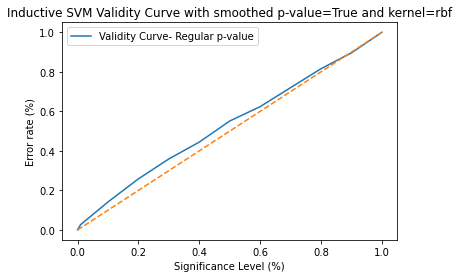

In [22]:
error_rate_smooth_rbf=[]#Initialize errorrate
significance_level=[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]#assign  different significance level
for point in significance_level : #Loop with different significance level
    prediction_set=[0] * len(x_test)#Initialize the variables
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(icp_rbf_smooth[3][i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth_rbf=np.append(error_rate_smooth_rbf,error/len(x_test))#calculate error rate
plt.plot(significance_level,error_rate_smooth_rbf)#plot te graph with error rate and significance level
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.plot([0,1],[0,1],"--")
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)",)
plt.title("Inductive SVM Validity Curve with smoothed p-value=True and kernel=rbf")

#### Implement SVM when kernel = "poly"

In [23]:
#Implement SVM when kernel = poly
from sklearn import metrics
svc_poly = svm.SVC(kernel='poly')
svc_poly.fit(x_train, y_train)
y_pred=svc_poly.predict(x_test)
print("Accuracy of SVM when kernel is poly:",metrics.accuracy_score(y_test,y_pred))

Accuracy of SVM when kernel is poly: 0.9347284504235177


Implementing Inductive conformal prediction algorithm in SVM with kernel =poly and regular p-value

In [24]:
#Implementing Inductive conformal prediction algorithm when kernel =poly with regular p-value
def svm_icp_poly(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test):#A defining a function svm_icp_poly and with arguments
    #calling the function set_variables
    total_p_values, p_values, prediction, confidence, credibility, false_p_value = \
    set_variables(y_train_proper,x_test) 
    cal_fun=svc_poly.decision_function(x_cal)#Calculate non-conformity scores for the calibration set
    row=np.arange(0,len(cal_fun))
    ncs_cal=-1*cal_fun[row,y_cal]
    test_fun=svc_poly.decision_function(x_test)#Calculate non-conformity scores for the test set
    #Loop through test samples
    for i in range(len(x_test)):
        for j in set(y_train_proper): #Test all possible labels
            ncs_test=np.append(ncs_cal,(-1*test_fun[i][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(ncs_test>=ncs_test[-1])
         #Use p-values of test sample to calculate various measures   
        prediction[i]=int(np.argmax(p_values[i]))#Measure prediction
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]#Measure Confidence
        credibility[i]=np.max(p_values[i])#Measure credibility
        total_p_values = total_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]#Measure total sum of p-values
    false_p_value=total_p_values/(2*len(x_test))#Measure false_p_value
    return prediction, confidence, credibility, p_values, false_p_value

In [25]:
start_time = time.time() # Calculate the total run time 
icp_poly=svm_icp_poly(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test) # Calling the function svm_icp_poly where kernel =poly and smooth =False
print("Total run time is: %s seconds " % (time.time() - start_time))#Result of the total run time
print(" Accuracy of icp with poly kernel and regular p-value: ", np.mean(icp_poly[0]==y_test))#Result of the Accuracy
print("Average False p-value: ", icp_poly[4])#Result the Average False p-value
print("Average Credibility: ",np.mean(icp_poly[2]))#Result of the Average Credibility
print("Average Confidence: ",np.mean(icp_poly[1]))#Result of the Average Confidence

Total run time is: 3.1357967853546143 seconds 
 Accuracy of icp with poly kernel and regular p-value:  0.9357249626307922
Average False p-value:  0.013920849395536726
Average Credibility:  0.5176848136784412
Average Confidence:  0.995693799770977


Validity curve with kernel = poly and regular p-value

Text(0.5, 1.0, 'Inductive SVM Validity Curve with smoothed p-value=false and kernel=poly')

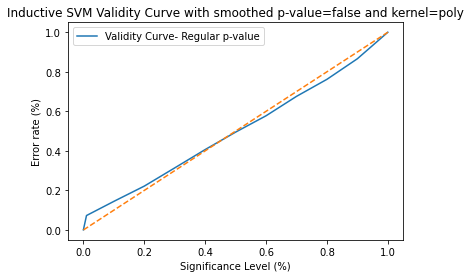

In [26]:
error_rate_smooth_poly=[]#Initialize errorrate
significance_level=[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]#assign  different significance level
for point in significance_level : #Loop with different significance level
    prediction_set=[0] * len(x_test)#Initialize the variables
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(icp_poly[3][i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth_poly=np.append(error_rate_smooth_poly,error/len(x_test))#calculate error rate
plt.plot(significance_level,error_rate_smooth_poly)#plot te graph with error rate and significance level
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.plot([0,1],[0,1],"--")
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)",)
plt.title("Inductive SVM Validity Curve with smoothed p-value=false and kernel=poly")

In [27]:
#Implementing Inductive conformal prediction algorithm when kernel =poly with smoothed p-value
def svm_icp_poly_smooth(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test):#A defining a function svm_icp_poly_smooth 
    #calling the function set_variables
    total_p_values, p_values, prediction, confidence, credibility, false_p_value = \
    set_variables(y_train_proper,x_test) 
    cal_fun=svc_poly.decision_function(x_cal)#Calculate non-conformity scores for the calibration set
    row=np.arange(0,len(cal_fun))
    ncs_cal=-1*cal_fun[row,y_cal]
    test_fun=svc_poly.decision_function(x_test)#Calculate non-conformity scores for the test set
    #Loop through test samples
    for i in range(len(x_test)):
        for j in set(y_train_proper): #Test all possible labels
            ncs_test=np.append(ncs_cal,(-1*test_fun[i][j]))
            #Calculate p-values of test sample
           #smooth == True:
            tau=np.random.uniform()
            p_values[i][j]=(np.sum(ncs_test>ncs_test[-1])+(tau*(np.sum(ncs_test==ncs_test[-1]))))/len(ncs_test)
         #Use p-values of test sample to calculate various measures   
        prediction[i]=int(np.argmax(p_values[i]))#Measure prediction
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]#Measure Confidence
        credibility[i]=np.max(p_values[i])#Measure credibility
        total_p_values = total_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]#Measure total sum of p-values
    false_p_value=total_p_values/(2*len(x_test))#Measure false_p_value
    return prediction, confidence, credibility, p_values, false_p_value

In [28]:
start_time = time.time() # Calculate the total run time 
icp_poly_smooth=svm_icp_poly_smooth(x_train_proper,y_train_proper,x_cal,y_cal,x_test,y_test) # Calling the function svm_icp_poly_smooth where kernel =poly and smooth =True
print("Total run time is: %s seconds " % (time.time() - start_time))#Result of the total run time
print(" Accuracy of icp with poly kernel and regular p-value: ", np.mean(icp_poly_smooth[0]==y_test))#Result of the Accuracy
print("Average False p-value: ", icp_poly_smooth[4])#Result the Average False p-value
print("Average Credibility: ",np.mean(icp_poly_smooth[2]))#Result of the Average Credibility
print("Average Confidence: ",np.mean(icp_poly_smooth[1]))#Result of the Average Confidence

Total run time is: 3.465869188308716 seconds 
 Accuracy of icp with poly kernel and regular p-value:  0.9357249626307922
Average False p-value:  0.012698845179293742
Average Credibility:  0.5174162100430117
Average Confidence:  0.9959549167491146


Text(0.5, 1.0, 'Inductive SVM Validity Curve with smoothed p-value=True and kernel=poly')

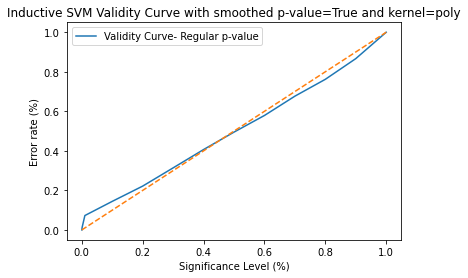

In [29]:
error_rate_smooth_poly=[]#Initialize errorrate
significance_level=[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]#assign  different significance level
for point in significance_level : #Loop with different significance level
    prediction_set=[0] * len(x_test)#Initialize the variables
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(icp_poly_smooth[3][i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth_poly=np.append(error_rate_smooth_poly,error/len(x_test))#calculate error rate
plt.plot(significance_level,error_rate_smooth_poly)#plot te graph with error rate and significance level
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.plot([0,1],[0,1],"--")
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)",)
plt.title("Inductive SVM Validity Curve with smoothed p-value=True and kernel=poly")